## Sentiment Analysis of 3.6M Amazon Reviews

### IE 7500, Summer 2025, Group 3: Richard Dam, Chien Nguyen, Trevor Sparks, Ernest Zeng

Amazon Review: https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews/data

Using mainly untrained, deep models trained on varying sizes of the Kaggle dataset, the objective of the project is to create deep models that can predict the label of the Amazon Reviews with acceptable accuracy.

In [1]:
import os
import pandas as pd
import numpy as np
import re
import string
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import tqdm as notebook_tqdm
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from collections import Counter

from utils.kaggle_data_loader import KaggleDataLoader
from utils.kaggle_dataset import KaggleDataSet

e:\life\edu\NU-DAE\IE 7500 - NLP\proj\venv-nlp-torch-bert-gradio-vscode\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Kaggle path
kaggle_path = "kritanjalijain/amazon-reviews"

kaggle_data_loader = KaggleDataLoader(kaggle_path)
path = kaggle_data_loader.load_data(KaggleDataSet.get_kaggle_column_names())

###print("Path to dataset files:", path)
###print(path)
###print(os.listdir(path))

kaggle_dataset = KaggleDataSet(kaggle_data_loader)
train_df = kaggle_dataset.get_train_df()
test_df = kaggle_dataset.get_test_df()

print(train_df.head())

train_texts = train_df[KaggleDataSet.get_review_column_name()].tolist()
test_texts = test_df[KaggleDataSet.get_review_column_name()].tolist()

train_labels = (train_df[KaggleDataSet.get_kaggle_polarity_column_name()]).tolist() 
test_labels = (test_df[KaggleDataSet.get_kaggle_polarity_column_name()]).tolist()

print("Train shape:", train_df.shape)
print("Test shape: ", test_df.shape)

   Kaggle_Label                                              Title  \
0             2                     Stuning even for the non-gamer   
1             2              The best soundtrack ever to anything.   
2             2                                           Amazing!   
3             2                               Excellent Soundtrack   
4             2  Remember, Pull Your Jaw Off The Floor After He...   

                                              Review  
0  This sound track was beautiful! It paints the ...  
1  I'm reading a lot of reviews saying that this ...  
2  This soundtrack is my favorite music of all ti...  
3  I truly like this soundtrack and I enjoy video...  
4  If you've played the game, you know how divine...  
Train shape: (3600000, 3)
Test shape:  (400000, 3)


In [3]:
print("Unique Kaggle label counts.  Unique values should be 1s and 2s")
print(train_df[KaggleDataSet.get_kaggle_polarity_column_name()].value_counts())
print(test_df[KaggleDataSet.get_kaggle_polarity_column_name()].value_counts())

Unique Kaggle label counts.  Unique values should be 1s and 2s
Kaggle_Label
2    1800000
1    1800000
Name: count, dtype: int64
Kaggle_Label
2    200000
1    200000
Name: count, dtype: int64


In [4]:
train_review_lengths = train_df[KaggleDataSet.get_review_column_name()].str.len()
print("Train dataset, Review column's length:\n")
reformatted_desc = train_review_lengths.describe().round(2)

# Convert from scientific notation to 2 decimal only
print(reformatted_desc.apply(lambda x: f"{x:.2f}"))

Train dataset, Review column's length:

count    3600000.00
mean         405.14
std          234.27
min            4.00
25%          207.00
50%          356.00
75%          566.00
max         1010.00
Name: Review, dtype: object


In [5]:
test_review_lengths = test_df[KaggleDataSet.get_review_column_name()].str.len()
print("Test dataset, Review column's length:\n")
reformatted_desc = test_review_lengths.describe().round(2)

# Convert from scientific notation to 2 decimal only
print(reformatted_desc.apply(lambda x: f"{x:.2f}"))

Test dataset, Review column's length:

count    400000.00
mean        404.90
std         234.11
min          15.00
25%         207.00
50%         356.00
75%         565.00
max        1009.00
Name: Review, dtype: object


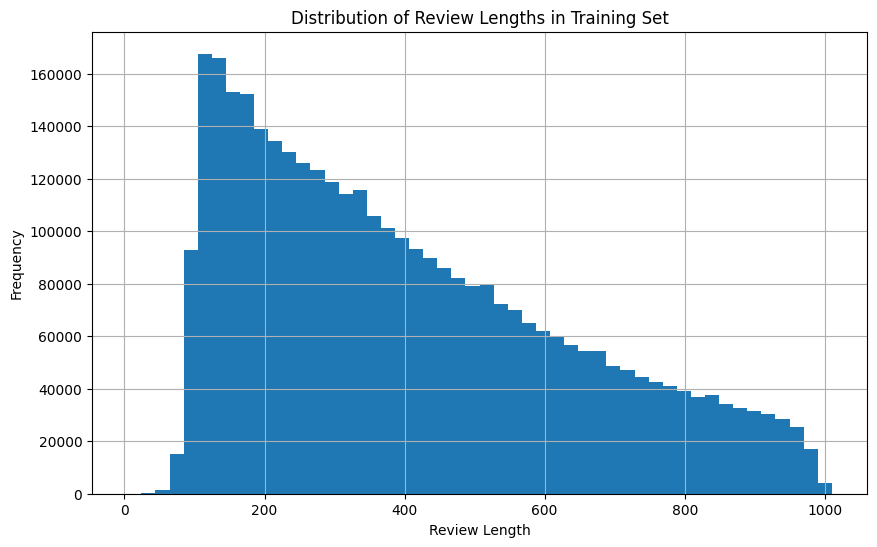

In [6]:
text_length_df = train_df[KaggleDataSet.get_review_column_name()].copy()
text_length_df['text_length_column'] = train_df[KaggleDataSet.get_review_column_name()].str.len()

### Visualize review text length distribution in training set
plt.figure(figsize=(10, 6))
text_length_df['text_length_column'].hist(bins=50)
plt.title('Distribution of Review Lengths in Training Set')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

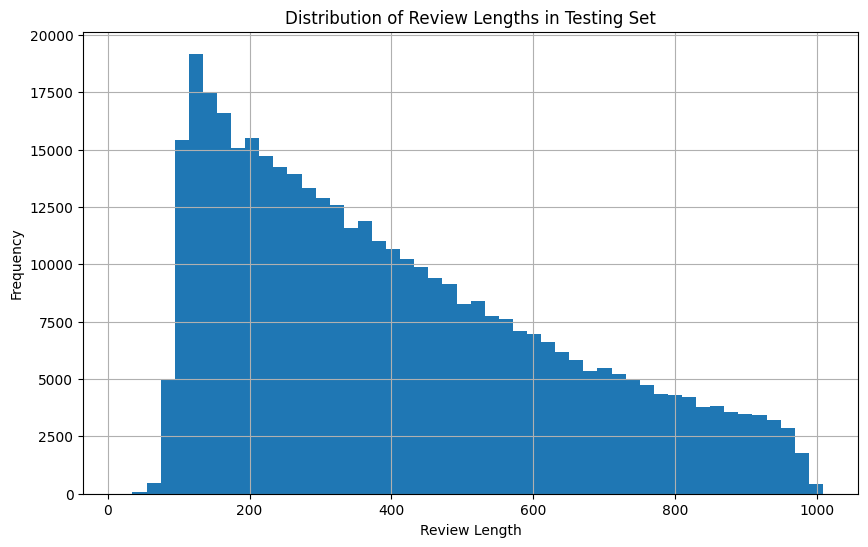

In [7]:
test_text_length_df = test_df[KaggleDataSet.get_review_column_name()].copy()
test_text_length_df['text_length_column'] = test_df[KaggleDataSet.get_review_column_name()].str.len()

### Visualize review text length distribution in testing set
plt.figure(figsize=(10, 6))
test_text_length_df['text_length_column'].hist(bins=50)
plt.title('Distribution of Review Lengths in Testing Set')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

In [8]:
###
### This may take a bit of time to run
###

'''

from itertools import chain

def get_unique_words(series):
    # To lowercase and split into words, handling NaN
    words = (review.lower().split() for review in series if isinstance(review, str))
    # Flatten and convert to set
    return set(chain(*words))


# Apply to 'review' column
unique_words = get_unique_words(train_df[KaggleDataSet.REVIEW_COLUMN_NAME])
num_unique_words = len(unique_words)

print(f"Number of unique words in all the reviews: {num_unique_words}")
'''

'\n\nfrom itertools import chain\n\ndef get_unique_words(series):\n    # To lowercase and split into words, handling NaN\n    words = (review.lower().split() for review in series if isinstance(review, str))\n    # Flatten and convert to set\n    return set(chain(*words))\n\n\n# Apply to \'review\' column\nunique_words = get_unique_words(train_df[KaggleDataSet.REVIEW_COLUMN_NAME])\nnum_unique_words = len(unique_words)\n\nprint(f"Number of unique words in all the reviews: {num_unique_words}")\n'

In [9]:
### Generate word cloud for the title column

avg_title_length = int(round(train_df[KaggleDataSet.get_title_column_name()].str.len().mean()))
print(f"Average Title length {avg_title_length}")

title_wordcloud = WordCloud(background_color='black', max_words=avg_title_length).generate(str(train_df[KaggleDataSet.get_title_column_name()]))

Average Title length 25


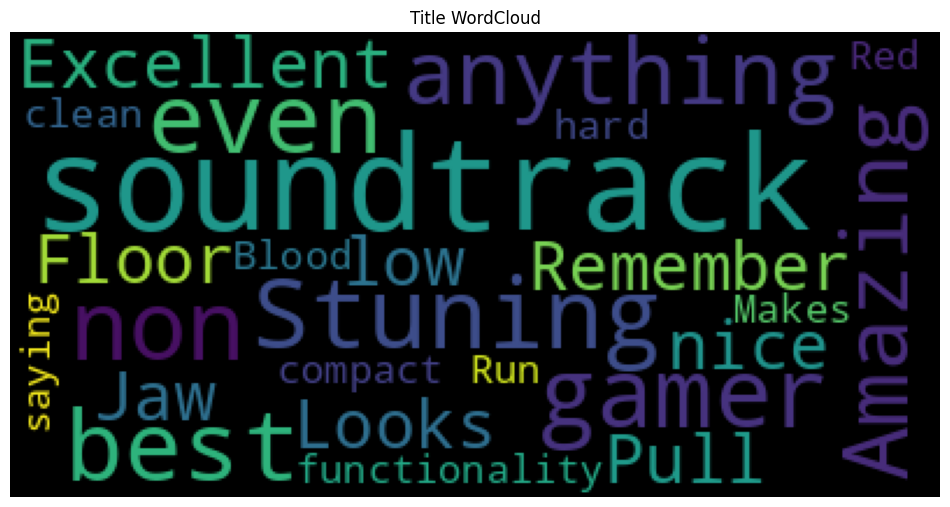

In [10]:
fig = plt.figure(figsize=[12,12])
plt.title('Title WordCloud')
plt.axis('off')
plt.imshow(title_wordcloud)
plt.show()

In [11]:
### Generate word cloud for the review column

avg_review_length = int(round(train_df[KaggleDataSet.get_review_column_name()].str.len().mean()))
print(f"Average Review length {avg_review_length}")

review_wordcloud = WordCloud(background_color='black', max_words=avg_review_length).generate(str(train_df[KaggleDataSet.get_review_column_name()]))

Average Review length 405


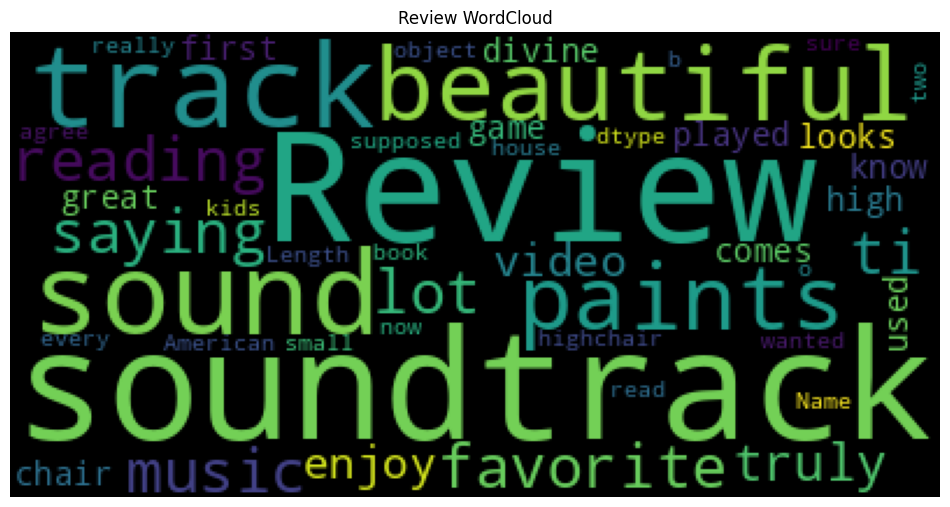

In [12]:
fig = plt.figure(figsize=[12,12])
plt.title('Review WordCloud')
plt.axis('off')
plt.imshow(review_wordcloud)
plt.show()

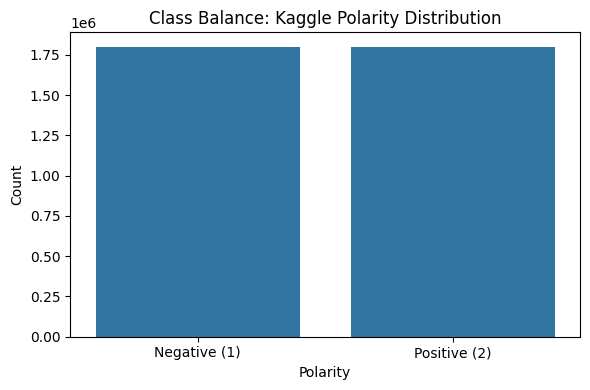

In [13]:
###
### Polarity Balance.  Are there more positive than negative polarity or vice versa or it's balanced
###
plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x=KaggleDataSet.get_kaggle_polarity_column_name())
plt.title('Class Balance: Kaggle Polarity Distribution')
plt.xticks([0, 1], ['Negative (1)', 'Positive (2)'])
plt.ylabel('Count')
plt.xlabel('Polarity')
plt.tight_layout()
plt.show()

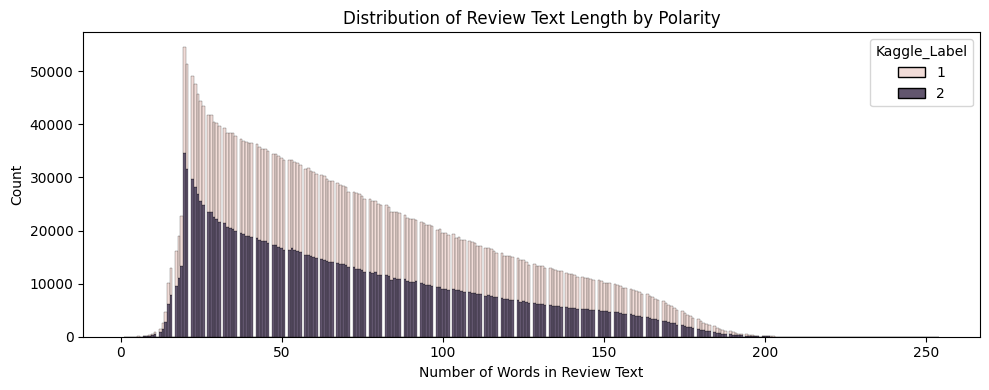

In [14]:
### Make a copy of the dataframe
df = train_df.copy()

### Check for null values
null_value_count_for_review_column = df[KaggleDataSet.get_review_column_name()].isnull().sum()

### Replace null values with an empty string
if null_value_count_for_review_column > 0:
    df[KaggleDataSet.get_review_column_name()] = df[KaggleDataSet.get_review_column_name()].fillna('')

# Add length columns
df['review_text_len'] = df[KaggleDataSet.get_review_column_name()].apply(lambda x: len(x.split()))

###
### Review Length Distribution
###
plt.figure(figsize=(10, 4))
sns.histplot(data=df, x='review_text_len', hue=KaggleDataSet.get_kaggle_polarity_column_name(), multiple='stack')
plt.title('Distribution of Review Text Length by Polarity')
plt.xlabel('Number of Words in Review Text')
plt.tight_layout()
plt.show()

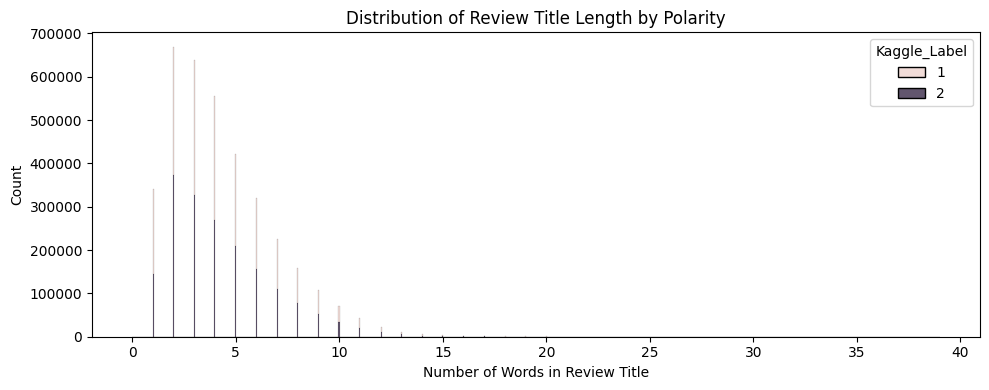

In [15]:
###
### Check for null values
###
null_value_count_for_title_column = df[KaggleDataSet.get_title_column_name()].isnull().sum()

### Replace null values with an empty string
if null_value_count_for_title_column > 0:
    df[KaggleDataSet.get_title_column_name()] = df[KaggleDataSet.get_title_column_name()].fillna('')

df['review_title_len'] = df[KaggleDataSet.get_title_column_name()].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 4))
sns.histplot(data=df, x='review_title_len', hue=KaggleDataSet.get_kaggle_polarity_column_name(), multiple='stack')
plt.title('Distribution of Review Title Length by Polarity')
plt.xlabel('Number of Words in Review Title')
plt.tight_layout()
plt.show()

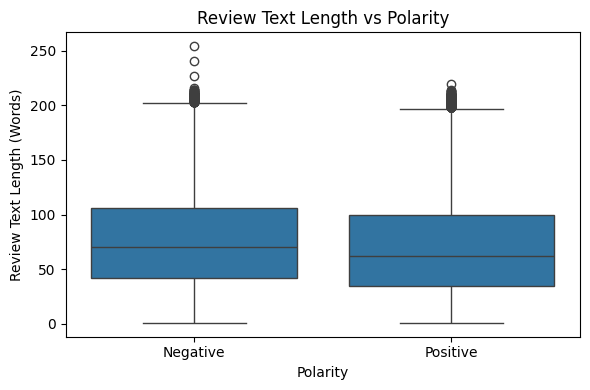

In [16]:
###
### Review Length vs Polarity (Boxplot)
###
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x=KaggleDataSet.get_kaggle_polarity_column_name(), y='review_text_len')
plt.title('Review Text Length vs Polarity')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.xlabel('Polarity')
plt.ylabel('Review Text Length (Words)')
plt.tight_layout()
plt.show()

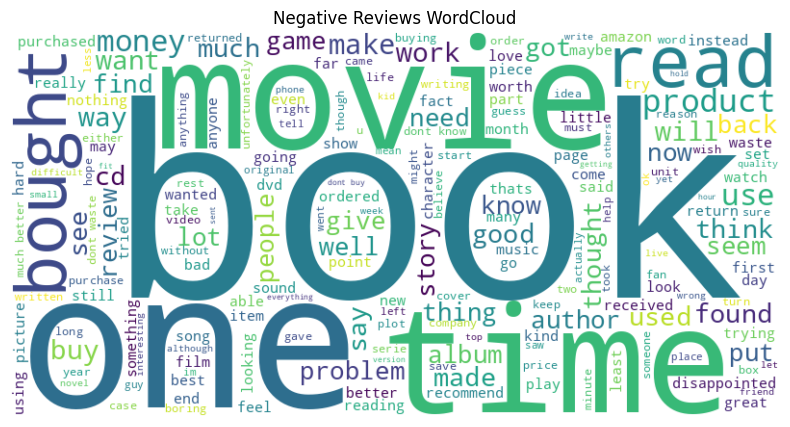

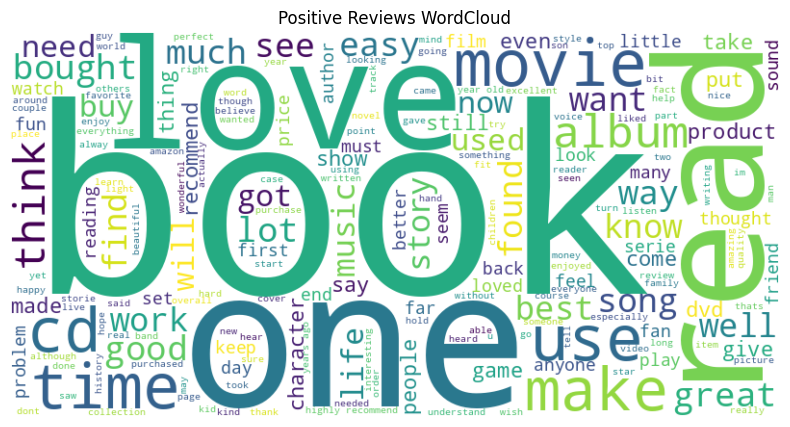

In [17]:
###
### WordClouds by Polarity
###

###
### NOTE: This may take some time to run!!!
###

def preprocess_text(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    return text

neg_text = " ".join(df[df[KaggleDataSet.get_kaggle_polarity_column_name()] == 1][KaggleDataSet.get_review_column_name()].apply(preprocess_text))
pos_text = " ".join(df[df[KaggleDataSet.get_kaggle_polarity_column_name()] == 2][KaggleDataSet.get_review_column_name()].apply(preprocess_text))

wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(neg_text)
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(pos_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Reviews WordCloud")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Reviews WordCloud")
plt.show()


In [18]:
###
### Using TF-IDF list the top word scoring for each polarity
### 
def get_top_tfidf_words(corpus, top_n=10):
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(corpus)
    tfidf_scores = X.sum(axis=0).A1
    terms = vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame({'term': terms, 'score': tfidf_scores})
    return tfidf_df.sort_values(by='score', ascending=False).head(top_n)

tfidf_neg = get_top_tfidf_words(df[df[KaggleDataSet.get_kaggle_polarity_column_name()] == 1][KaggleDataSet.get_review_column_name()])
tfidf_pos = get_top_tfidf_words(df[df[KaggleDataSet.get_kaggle_polarity_column_name()] == 2][KaggleDataSet.get_review_column_name()])

### Combine the TF-IDF dataframes side by side for easier visualization
combined_tfidf = pd.concat({
    "Negative": tfidf_neg.reset_index(drop=True),
    "Positive": tfidf_pos.reset_index(drop=True)
}, axis=1)


In [19]:
print(combined_tfidf)

  Negative               Positive              
      term         score     term         score
0     book  53855.354796     book  56190.079098
1     just  31527.267399    great  41130.955373
2     like  31164.950686     good  33960.460361
3    movie  26730.788024     like  30041.150104
4     good  25876.622201     read  28743.907405
5      don  24129.182116     just  26436.046991
6     time  23990.301781     love  26137.494024
7  product  22646.895021    movie  24811.141041
8     read  21858.641418   really  22912.327578
9   really  20468.634301     time  22699.095610


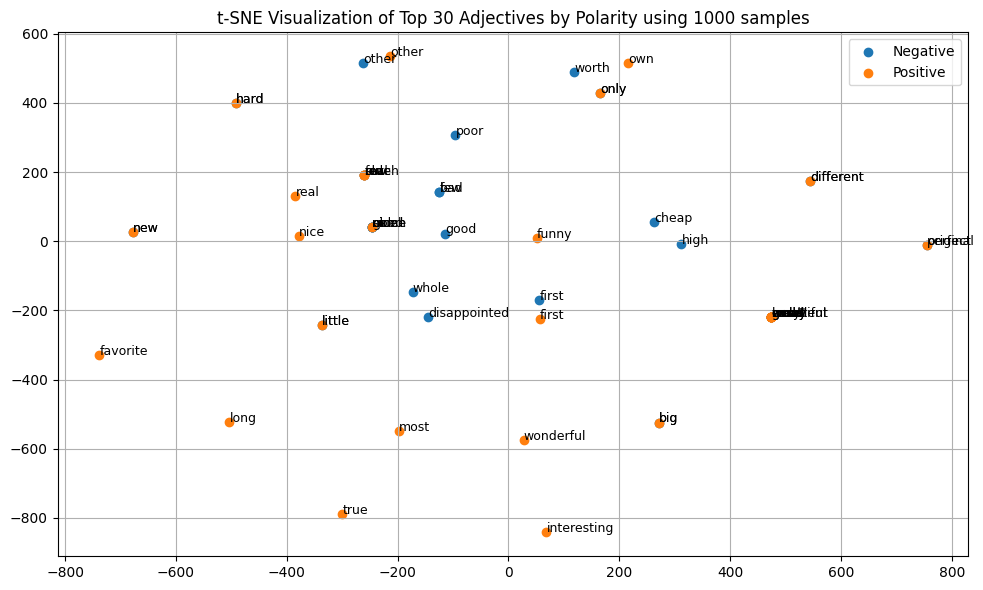

In [20]:
###
### Visualize the top 30 or so adjectives from both positive and negative reviews.  Only sample a representive set of reviews.
### Use tSNE to perform embedding dimensionality reduction in order to visualize the adjectives in 2D.
##

### Load spacy medium size vocabulary since it contains embeddings
nlp = spacy.load("en_core_web_md")

### Variables to control the different sizing
random_state_seed = 101
num_review_sample_size = 1000
top_n_common_adjectives = 30
tsne_perplexity_value = 5
tsne_max_iter = 1000
tsne_num_dim = 2

##
### Extract positive and negative polarity reviews, only extract num_review_sample_size samples to
### minimize the processing time.  Otherwise, extracting all the reviews will take a long time
###
neg_texts = df[df[KaggleDataSet.get_kaggle_polarity_column_name()] == 1][KaggleDataSet.get_review_column_name()].sample(n=num_review_sample_size, random_state=random_state_seed)
pos_texts = df[df[KaggleDataSet.get_kaggle_polarity_column_name()] == 2][KaggleDataSet.get_review_column_name()].sample(n=num_review_sample_size, random_state=random_state_seed)

###
### Internal function to extract adjectives
###
def extract_adjectives(texts):
    adjectives = []

    ### Do not load the "ner" (Name Entity Recognition) or "parser" (sentence structure parsing) components
    ### into the spacy pipeline in order to reduce processing time.
    for doc in nlp.pipe(texts, batch_size=1000, disable=["ner", "parser"]):

        ### Check the part of speech (POS) of each token and only pick tokens that are "ADJectives"
        adjectives += [token.lemma_.lower() for token in doc if token.pos_ == "ADJ"]
    return adjectives

neg_adjs = extract_adjectives(neg_texts)
pos_adjs = extract_adjectives(pos_texts)

### From both the positive and negative adjectives, only pick out the top_n_common_adjectives
neg_top = [word for word, _ in Counter(neg_adjs).most_common(top_n_common_adjectives)]
pos_top = [word for word, _ in Counter(pos_adjs).most_common(top_n_common_adjectives)]

#### Combine all the adjectives but ensure we have the adjective's polarity in a parallel vector
all_adjs = neg_top + pos_top
polarities = ["Negative"] * len(neg_top) + ["Positive"] * len(pos_top)

### Get the spacy embedding of all the adjectives.
vectors = np.array([nlp(word).vector for word in all_adjs])

### t-SNE dimensionality reduction of the emebddings to 2D in order to visualize it
tsne = TSNE(n_components=tsne_num_dim, 
            random_state=random_state_seed, 
            perplexity=tsne_perplexity_value, 
            max_iter=tsne_max_iter)
reduced = tsne.fit_transform(vectors)

df_plot = pd.DataFrame({
    "adjective": all_adjs,
    "x": reduced[:, 0],
    "y": reduced[:, 1],
    "polarity": polarities
})

plt.figure(figsize=(10, 6))
for label in df_plot["polarity"].unique():
    subset = df_plot[df_plot["polarity"] == label]
    plt.scatter(subset["x"], subset["y"], label=label)
    for _, row in subset.iterrows():
        plt.text(row["x"] + 0.5, row["y"] + 0.5, row["adjective"], fontsize=9)
plt.title(f"t-SNE Visualization of Top {top_n_common_adjectives} Adjectives by Polarity using {num_review_sample_size} samples")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In the above visual of the top adjectives (by frequency) base on polarity, there are adjectives that appear in both positve and negative polarity reviews like 'other', 'first', the overlapping ones.  Adjectives like 'cheap', 'high' (prices?), poor (quality?), (not?) 'worth' (it?), 'disappointed', for example, are associated with negative reviews.  On the other hand, 'wonderful', 'nice', 'new', 'favorite', 'interesting' (books or movies?), 'big', 'real' (bargain?), 'hard', 'different', for examples, are associated with positive polarity reviews.